In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.spatial import distance as spdist
#clear warnings

# Metrics

Below we define a collection of metrics to use in our knn algorithms

In [2]:
# Euclidean distance for a df sample 
def euc_dist(x1,x2,*args):
    total = 0
    for i in range(x2.size):
        total += (x1[i] - x2[i])**2
    return total**0.5

# Manhattan distance
def man_dist(x1,x2,*args):
    total = 0
    for i in range(x2.size):
        total += abs(x1[i] - x2[i])
    return total

def mala_dist(x1,x2,v):
    return spdist.mahalanobis(x1,x2,v)

# Choosing metric for algorithm
def metric_func(x):
    if x == 'man_dist':
        return man_dist
    if x == 'mala_dist':
        return mala_dist
    else:
        return euc_dist
    


The following function will return the prediction from the list of nearest neighbors, either by simple sum (weight='even') or by weighted average (weight='proportional').

In [3]:
def cat_pred(cat_list,dist_list,weight='even'):
    if weight =='even':
        return (np.argmax((pd.Series(cat_list).value_counts())),0)
    elif weight =='proportional':
        list_sum = []
        list_index = []
        for x in cat_list:
            sumx = 0
            totalx = 0
            for i in range(len(cat_list)):
                if cat_list[i] == x:
                    sumx += dist_list[i]
                    totalx += 1
            list_sum.append(sumx / totalx)
        return (cat_list[np.argmin(np.array(list_sum))],np.amin(np.array(list_sum)))

# Algorithms

In [15]:
def knn_full(train,test,y,k,weight='even',metric='euc_dist',optional='none'):
    '''
    train: pandas dataframe (with both input and output variables)
    test: pandas dataframe (with only input variables)
    y: string (output name, e.g. 'species')
    k: KNN model hyperparameter
    y_predict (output): list
    weight: can be 'even' or 'proportional'
    metric: choose different types of metrics
    output: for each element in the test set, it returns the predicted value, along
            with a list of indices of the k nearest neighbors (from the train set), their distances,
            their y value,and in the case of proportional distance, the average distance for this set.
    '''
    train.reset_index(drop=True,inplace=True)
    test.reset_index(drop=True,inplace=True)
    X_train = train.drop(columns=[y])
    y_predict = []
    for i in range(test.shape[0]):
        knn_list = []
        knn_dist = []
        knn_index = []
        for j in range(train.shape[0]):
            dist_ij = metric_func(metric)(test.iloc[i,:],X_train.iloc[j,:],optional)
            if len(knn_list) < k:
                knn_dist.append(dist_ij)
                knn_list.append(train.at[j,y])
                knn_index.append(j)
            elif dist_ij < np.amax(np.array(knn_dist)):
                # Where the larger distance was, assign new one
                max_ind = np.argmax(np.array(knn_dist))
                knn_list[max_ind],knn_dist[max_ind],knn_index[max_ind] = train.loc[j,y],dist_ij,j
        # Most repeated category 
        rep_cat = cat_pred(knn_list,knn_dist,weight=weight)
        y_predict.append((rep_cat[0],knn_index,knn_dist,knn_list,rep_cat[1],test.iloc[i,:]))
    return y_predict

In [16]:
def knn(train,test,y,k):
    '''
    train: pandas dataframe (with both input and output variables)
    test: pandas dataframe (with both input and output variables)
    y: string (output name, e.g. 'species')
    k: KNN model hyperparameter
    y_predict (output): list
    weight: can be 'even' or 'proportional'
    metric: choose different types of metrics
    output: for each element in the test set, it returns the predicted value, along
            with a list of indices of the k nearest neighbors (from the train set), their distances,
            their y value,and in the case of proportional distance, the average distance for this set.
    '''
    y_predict = []
    result = knn_full(train,test,y,k)
    for i in range(len(result)):
        y_predict.append(result[i][0])
    return y_predict

In [9]:
prueba = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
prueba

,0,1
0,3.30,1.00
1,3.32,1.00
2,3.34,1.00
3,3.36,1.00
4,3.38,1.00
...,...,...
61595,8.80,5.38
61596,8.82,5.38
61597,8.84,5.38
61598,8.86,5.38


# Animation: nearest neighbor search

In [ ]:
from celluloid import Camera
from IPython.display import HTML
colors = {'setosa':'red', 'versicolor':'blue', 'virginica':'green'}

In [ ]:
def animate_knn(df,k,weight='even',metric='euc_dist'):
    
    # Initialize animation with the data point we are going to predict
    X = df.iloc[0,:].to_frame().transpose()
    plt.scatter(X['len'],X['wid'],s=1200,marker='D',c='black')
    
    # Legend details for initialization
    leg_pred = mpatches.Patch(color='black',label='Prediction: '+''.ljust(15))
    leg_actual = mpatches.Patch(color=colors[X.loc[0,'species']],label='Actual: '+X.loc[0,'species'])
    leg_steps = mpatches.Patch(color='white',label='Last change: ')
    steps = 1
    leg_dist = mpatches.Patch(color='white',label='Actual: '+X.loc[0,'species'])
    if weight == 'even':
        plt.legend(handles=[leg_pred,leg_actual,leg_steps],fontsize='medium')
    elif weight == 'proportional':
        plt.legend(handles=[leg_pred,leg_actual,leg_steps,leg_dist],fontsize='medium')
    
    # Take snap
    camera.snap()

    for i in range(2,df.shape[0]-2):
        # Calculate and plot each point
        k_par = k
        X1 = df.iloc[1:i,:]
        output = knn_full(X1,X,'species',k_par,weight=weight,metric=metric)
        pred = output[2][0][0]
        pred_index = output[2][0][1]
        pred_dist = output[2][0][4]
        plt.scatter(X['len'],X['wid'],s=1200,marker='D',c=colors[pred])
        plt.scatter(X1['len'],X1['wid'],s=200,marker='o',c=X1['species'].apply(lambda x: colors[x]),alpha=0.5)
        # Check for change of prediction
        if i > 2 and pred != last_output[2][0][0]:
            steps = i-1
            leg_steps = mpatches.Patch(color=colors[pred],label='Last change: '+str(steps)+' samples')
        
        #Legend details
        leg_pred = mpatches.Patch(color=colors[pred],label='Prediction: '+pred.ljust(15))
        leg_actual = mpatches.Patch(color=colors[X.loc[0,'species']],label='Actual: '+X.loc[0,'species'])
        leg_dist = mpatches.Patch(color=colors[pred],label='Dist Avg: '+str(round(pred_dist,4)).ljust(15))
        
        if weight == 'even':
            plt.legend(handles=[leg_pred,leg_actual,leg_steps],fontsize='medium')
        elif weight=='proportional':
            plt.legend(handles=[leg_pred,leg_actual,leg_steps,leg_dist],fontsize='medium')
        for j in pred_index:
            plt.scatter(X1.loc[j,'len'],X1.loc[j,'wid'],s=500,marker='o',c=colors[X1.loc[j,'species']],zorder=2)
        
        # Distance plot
        if i < df.shape[0]-3:
            if metric == 'man_dist':
                plt.plot([X1.at[i-2,'len'],X.loc[0,'len']],[X.loc[0,'wid'],X.loc[0,'wid']],linewidth=7,color='gray',zorder=1)
                plt.plot([X1.at[i-2,'len'],X1.at[i-2,'len']],[X1.at[i-2,'wid'],X.loc[0,'wid']],linewidth=7,color='gray',zorder=1)
            else:
                plt.plot([X1.at[i-2,'len'],X.loc[0,'len']],[X1.at[i-2,'wid'],X.loc[0,'wid']],linewidth=7,color='gray',zorder=1)
        else:
            plt.plot([X.loc[0,'len']],[X.loc[0,'wid']],linewidth=7,color=colors[pred],zorder=0)
        
        # Camera for animation, compute steps
        camera.snap()
        last_output = output

In [11]:
df = sns.load_dataset('iris')
# df = df[df.species.isin(['versicolor','virginica'])]
df_plot = df[['sepal_length','sepal_width','species']].reset_index(drop=True)
new_names = {'sepal_length':'len','sepal_width':'wid'}
df_plot.rename(columns=new_names,inplace=True)
df_plot = df_plot[(df_plot['wid'] < 3.25) & (df_plot['wid'] > 2.7)] 
df_plot = df_plot[(df_plot['len'] < 6.55) & (df_plot['len'] > 4)]
prng = np.random.RandomState(9)
df_plot = df_plot.sample(frac=1,random_state=prng,axis=0)
df_plot.reset_index(drop=True,inplace=True)
df_plot.head(10)

,len,wid,species
0,4.6,3.1,setosa
1,6.1,3.0,versicolor
2,6.4,2.8,virginica
3,5.0,3.0,setosa
4,5.8,2.8,virginica
5,4.6,3.2,setosa
6,6.3,2.9,virginica
7,5.7,3.0,versicolor
8,6.4,2.9,versicolor
9,4.8,3.0,setosa


In [18]:
prueba2 = prueba.iloc[1:30,:]
veamos = knn(df_plot,prueba,'species',3)
print(veamos)

KeyboardInterrupt: 

In [ ]:
# Base case: even weights, euclidean distance
fig = plt.figure(figsize=(7,7))
plt.axis([4,6.6,2.6, 3.5,])
camera = Camera(fig)
sns.set()
plt.rcParams['scatter.edgecolors'] = "black"

animate_knn(df_plot,10,weight='even')
animation1 = camera.animate(interval=1000,repeat=False)
HTML(animation1.to_html5_video())
animation1.save('prueba.mp4')
plt.close()

In [ ]:
# Proportional weights, euclidean distance: less samples for convergence

In [ ]:
# Manhattan distance
fig = plt.figure(figsize=(7,7))
plt.axis([4,6.6,2.6, 3.5,])
camera = Camera(fig)
sns.set()
plt.rcParams['scatter.edgecolors'] = "black"
colors = {'setosa':'red', 'versicolor':'blue', 'virginica':'green'}
animate_knn(df_plot,10,metric='man_dist',weight='proportional')
animation2 = camera.animate(interval=1000,repeat=False)
animation2.save('basic_animation.mp4')
plt.close()
# HTML(animation2.to_html5_video())

## Neighbourhood plotting

In [97]:
df_mesh = df.drop(columns=['petal_length','petal_width'])
df_mesh = df_mesh.sample(frac=0.1)
df_mesh

,sepal_length,sepal_width,species
48,5.3,3.7,setosa
131,7.9,3.8,virginica
40,5.0,3.5,setosa
141,6.9,3.1,virginica
121,5.6,2.8,virginica
139,6.9,3.1,virginica
71,6.1,2.8,versicolor
15,5.7,4.4,setosa
24,4.8,3.4,setosa
53,5.5,2.3,versicolor


In [89]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder

def create_mesh(train,y,k):
    X_train = train.drop(columns=[y]).reset_index(drop=True)
    h = .02  # step size in the mesh
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
    y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    z_mesh = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # WARNING: Long calculation
    Z = np.array(knn(train,z_mesh,y,k))
    # Encode predictions for plotting
    Z_flat = LabelEncoder().fit_transform(Z.flatten())
    Z_out = np.array(Z_flat)
    return (xx,yy,Z_out)

In [101]:
len([0,0,1,2,1,2,2,1,0,0,1,0,2,1,0])

15

In [103]:
def plot_mesh(train,y,k,name):
    X_train = train.drop(columns=[y]).reset_index(drop=True)
    mesh = create_mesh(train,y,k)
    xx,yy,Z_out = mesh[0],mesh[1],mesh[2]
    # OJO!!!
    label = [0,0,1,2,1,2,2,1,0,0,1,0,2,1,0]

    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    # Create figure, put the result into a color plot
    plt.figure(figsize=(7,7))
    plt.axis([4,6.6,2.6, 3.5,])
    Z = Z_out.reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points

    plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=label, cmap=cmap_bold,edgecolor='k', s=50)
    plt.title("kNN classification: (k=%r)"% k)
    plt.axis('tight')
    plt.savefig(name+'.png')
    plt.show()
    # plt.close()

    # ERROR: c=y, it should be c=label and df_plot encoded in 'species'

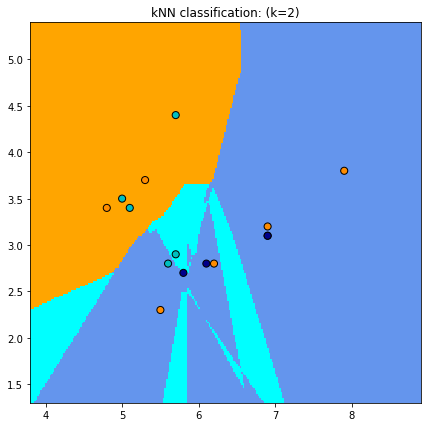

In [104]:
plot_mesh(df_mesh,'species',2,'knnveamos')

# df_prueba = df_mesh.iloc[:5,:].shape
# df_prueba